# The Electron Collection - Not Done

Electrons are single-track particles. They are reconstructed with energy deposits in the calorimeter and an associated track.

Outstanding:
* Need to understand tags - we can't re-run this on derivations (basically, nothing here works yet)

In [1]:
from func_adl_servicex_xaodr21 import SXDSAtlasxAODR21
import matplotlib.pyplot as plt
from config import ds
import awkward as ak
import numpy as np

Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.


The default electron we fetch is the so-called `MediumLHElectron` muon with `GradientMedium` isolation.

In [2]:
import logging
logging.basicConfig()
logging.getLogger("func_adl_xAOD.common.local_dataset").setLevel(level=logging.DEBUG)
from servicex import ignore_cache
with ignore_cache():
    electrons = (ds
                .SelectMany(lambda e: e.Electrons("Electrons", isolation="GradientLoose"))
                .Select(lambda m: m.pt() / 1000.0)
                .AsAwkwardArray('pt')
                .value())

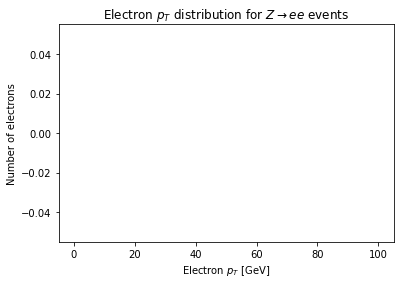

In [3]:
plt.hist(electrons.pt, bins=100, range=(0, 100))
plt.xlabel('Electron $p_T$ [GeV]')
plt.ylabel('Number of electrons')
_ = plt.title('Electron $p_T$ distribution for $Z\\rightarrow ee$ events')

## Muon Types

Muons come in several different flavors. In this sample with very few muons, we can look at the different $\eta$ distributions for what muons are there:

In [ ]:
muons = (ds
        .Select(lambda e: {
            'tight_eta': e.Muons("Muons", working_point='Tight').Select(lambda m: m.eta()),
            'loose_eta': e.Muons("Muons", working_point='Loose').Select(lambda m: m.eta()),
            'medium_eta': e.Muons("Muons", working_point='Medium').Select(lambda m: m.eta()),
        })
        .AsAwkwardArray()
        .value())

In [ ]:
plt.hist(ak.flatten(muons.loose_eta), bins=50, range=(-3, 3), label='loose')
plt.hist(ak.flatten(muons.medium_eta), bins=50, range=(-3, 3), label='medium')
plt.hist(ak.flatten(muons.tight_eta), bins=50, range=(-3, 3), label='tight')
plt.legend()

## Calibration

By default the muons we pulled are `Medium` quality and calibrated. One can request different systematic errors using the `calibration` argument to the `Muons` method.

In [ ]:
import logging
logging.basicConfig()
logging.getLogger("func_adl_xAOD.common.local_dataset").setLevel(level=logging.DEBUG)
from servicex import ignore_cache
with ignore_cache():
    muons = (ds
            .SelectMany(lambda e: e.Muons("Muons"))
            .Select(lambda j: {
                'pt': j.pt() / 1000.0,
                'eta': j.eta(),
                'phi': j.phi(),
            })
            .AsAwkwardArray()
            .value())

To grab the raw jets (without calibration) we just set the `calibrated` parameter to `False` (there is very little reason one will do this normally):

In [ ]:
raw_muons = (ds
             .SelectMany(lambda e: e.Muons("Muons", calibration=None))
             .Select(lambda j: {
                 'pt': j.pt() / 1000.0,
                 'eta': j.eta(),
                 'phi': j.phi(),
             })
             .AsAwkwardArray()
             .value())

The number of raw jets and the number of calibrated jets are quite different from the number of raw jets, so we'll need to match them in $\eta$ and $\phi$:

In [ ]:
len(raw_muons), len(muons)

In [ ]:
def match(jets, jets_to_match):
    'Find the closest eta/phi jet in jets_to_match for each jet in jets'

    by_jets = ak.cartesian([jets, jets_to_match], axis=0, nested=True)
    d_eta = np.abs(by_jets[:, :]["0"].eta - by_jets[0, :]["1"].eta)
    # TODO: Account for wrap around in phi
    d_phi = np.abs(by_jets[:, :]["0"].phi - by_jets[0, :]["1"].phi)
    delta = d_eta + d_phi

    # TODO: Window out any match over 0.2*0.2 in eta/phi
    best_match = ak.argmin(delta, axis=1)
    return jets_to_match[best_match]

raw_muons_matched = match(muons, raw_muons)

Note the units along the x-axis here!! We are using **MeV** not *GeV*!

In [ ]:
plt.hist((muons.pt-raw_muons_matched.pt), bins=50, range=(-0.5, 0.5))
plt.xlabel('$\Delta p_T$ for calibrated muons matched to their raw muons [MeV]')
plt.ylabel('Number of muons')
_ = plt.title('The effect of muon calibration on muon $p_T$ in $Z\\rightarrow ee$ events')

If we instead want a particular systematic error, we need only name that error to get it back. Knowing what the names of the systematic errors, however, is not something that can be programmatically determined ahead of time. See the further information section at the end of this chapter to links to the ATLAS muon calibration info twiki.

In [ ]:
sys_muon = (ds
           .SelectMany(lambda e: e.Muons("Muons", calibration="MUON_EFF_RECO_STAT__1up"))
           .Select(lambda m: {
               'pt': m.pt() / 1000.0,
               'eta': m.eta(),
               'phi': m.phi(),
           })
           .AsAwkwardArray()
           .value())

In [ ]:
sys_muons_matched = match(muon, sys_muon)

In [ ]:
plt.hist((muons.pt-sys_muons_matched.pt)/1000.0, bins=50, range=(-0.005, 0.005))
plt.xlabel('$\Delta p_T$ for calibrated muons matched to their reco stat muons [GeV]')
plt.ylabel('Number of muons')
_ = plt.title('The effect of a muon calibration sys error on muon $p_T$ in $Z\\rightarrow ee$ events')

Currently you only get the calibration that is loaded with the release. Selecting a particular calibration is a future feature!

## The Data Model

The data model when this documentation was last built is.

In [ ]:
from func_adl_servicex_xaodr21.xAOD.electron_v1 import Electron_v1
help(Electron_v1)

## Further Information

* The [`xAOD::Electron_v1` C++ header file](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODEgamma/xAODEgamma/versions/Electron_v1.h) with all the inline documentation.
* The [Electron Recommendation Pages for R21](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/LatestRecommendationsElectronIDRun2) on the ATLAS TWiki
* The [Electron Working Points Pages for R21](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/EGammaIdentificationRun2) on the ATLAS Twiki